<a href="https://colab.research.google.com/github/MickaRiv/ProjetDatascientest-VoiceSeparator/blob/Stan/notebooks/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs et imports

In [1]:
!pip install nussl

     |████████████████████████████████| 239 kB 5.1 MB/s 
     |████████████████████████████████| 146 kB 54.6 MB/s 
     |████████████████████████████████| 310 kB 48.1 MB/s 
     |████████████████████████████████| 240 kB 42.0 MB/s 
     |████████████████████████████████| 3.3 MB 35.6 MB/s 
     |████████████████████████████████| 51 kB 41 kB/s 
     |████████████████████████████████| 71 kB 155 kB/s 
     |████████████████████████████████| 87 kB 6.8 MB/s 
     |████████████████████████████████| 963 kB 45.3 MB/s 
     |████████████████████████████████| 130 kB 37.0 MB/s 
     |████████████████████████████████| 6.2 MB 33.9 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4710 sha256=1e654f7ef6ae2579c3462bae3a512834192163562c759ee901f2cecbf90e97e8
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509894 sha256=f2474a5be87d7ee0f52558

In [2]:
!pip install git+https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator

  Cloning https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator to /tmp/pip-req-build-xhjpn6q3
  Running command git clone -q https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator /tmp/pip-req-build-xhjpn6q3
  Created wheel for voice-separator: filename=voice_separator-0.0.1-py3-none-any.whl size=5583 sha256=25abc988427469a5e8fc2f4065f968f2f5ec7de6eca310460a88b4769ac8bf82
  Stored in directory: /tmp/pip-ephem-wheel-cache-_w36uq5p/wheels/89/ad/91/9cded351057b1a842fbbfa97f091da426d85036b0efd2e0273
Successfully built voice-separator


In [3]:
import os
import nussl
import librosa
from matplotlib import pyplot as plt
import numpy as np

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


# Montage du drive

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Récupération des données

In [5]:
from voicesep.core import get_musdb_data

path = os.path.join("/content",
                    "drive",
                    "MyDrive",
                    "Projet Datascientest",
                    "musdb18")
musdb = get_musdb_data(gather_accompaniment=True,folder=path)
musdb_train = get_musdb_data(gather_accompaniment=True,folder=path,subfolder="train")
musdb_test = get_musdb_data(gather_accompaniment=True,folder=path,subfolder="test")

Ces variables sont des hooks dataset, et pas directement l'entièreté des données (pour ne pas exploser la RAM). Il est possible d'accéder aux items du dataset par le getitem python classique : `musdb[i]`.

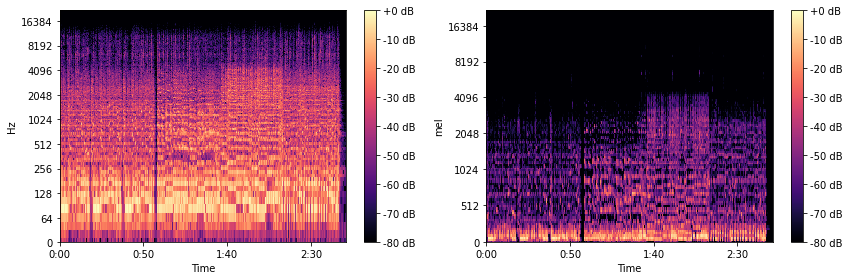

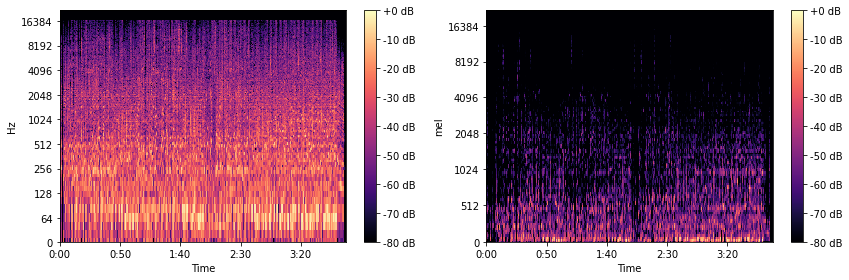

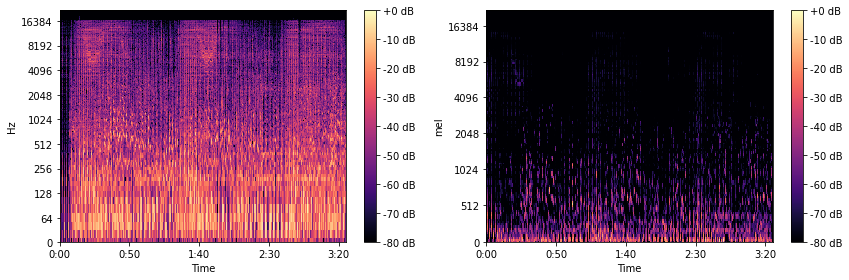

In [ ]:
for i in range(3):
  plt.figure(figsize=(12,4))

  plt.subplot(121)
  nussl.core.utils.visualize_spectrogram(musdb[i]['mix'],y_axis='log')
  plt.colorbar(format='%+2.0f dB')

  plt.subplot(122)
  nussl.core.utils.visualize_spectrogram(musdb[i]['mix'],y_axis="mel")
  plt.colorbar(format='%+2.0f dB')
  plt.ylabel("mel")
  plt.tight_layout()
  plt.show()

# Spectrogrammes et création du dataset

On calcule les spectrogrammes du mix (données d'entrée) et du vocals (ground truth). Les spectres sont concaténés puis découpés pour former une "image" (donnée d'entrée du U-net).
Rem. : faire une fonction, ce serait plus propre

In [6]:
# paramètres de la STFT
freq        =8192     # fréquence de reéchantillonage

window_length =1023    # taille fenêtre FFT
hop_length    =768     # recouvrement FFT

patch_size = 128      # taille du patch temporel pour le CNN (=128 frames temporels)


npistes=20#len(musdb_train)

k=0
time=0
for npiste in range(npistes):

# Spectro voix et mix
  voice=musdb_train[npiste]['sources']["vocals"]
  mix=musdb_train[npiste]['mix']

  time=time+voice.audio_data.shape[1]/voice.sample_rate 

# Resampling à 8 kHz (pour data plus light)
  voice=librosa.resample(voice.audio_data,voice.sample_rate,freq,res_type='kaiser_fast')
  mix  =librosa.resample(mix.audio_data,mix.sample_rate,freq,res_type='kaiser_fast')
# Passage en mono
  voice = librosa.to_mono(voice)
  mix   = librosa.to_mono(mix)
# fft mix et voix (magnitude normalisée et phase)
  stftvoice = librosa.stft(voice,n_fft=window_length,hop_length=hop_length)
  magvoice, phasevoice = librosa.magphase(stftvoice)

  stftmix = librosa.stft(mix,n_fft=window_length,hop_length=hop_length)
  magmix, phasemix = librosa.magphase(stftmix)

  norm = magmix.max()
  magmix /= norm
  magvoice /= norm

# concatenation
  k=k+1
  print("processing:",k)
  if (k==1):
    X_mix   =magmix
    X_voice =magvoice
    phase   =phasemix
  else:
    X_mix  =np.append(X_mix,magmix,axis=1)
    X_voice=np.append(X_voice,magvoice,axis=1)
    phase  =np.append(phase,phasemix,axis=1)


nfreq=X_mix.shape[0] 

# split en "images" temporelles de taille patch_size (128 dans le papier d'origine)
nimages=X_mix.shape[1]//patch_size   # nombre total d'images
newsize=nimages*patch_size           # nouvelle taille pour un découpage qui tombe juste 

print('Data set: ',k, 'songs')
print('Data set: ',time, 'total time (s)')
print('Data set: ',nimages, 'training images with size',nfreq,'x',patch_size)

X_mix_resized  =X_mix  [:,:newsize]
X_voice_resized=X_voice[:,:newsize]
phase_resized=phase[:,:newsize]

X_mix=np.array(np.split(X_mix_resized, nimages, axis=1))    # découpage 
X_voice=np.array(np.split(X_voice_resized, nimages, axis=1))
phase=np.array(np.split(phase_resized, nimages, axis=1))

X_mix=np.expand_dims(X_mix,axis=3) # rajout d'une dimension (canal) 
X_voice=np.expand_dims(X_voice,axis=3)


processing: 1
processing: 2
processing: 3
processing: 4
processing: 5
processing: 6
processing: 7
processing: 8
processing: 9
processing: 10
processing: 11
processing: 12
processing: 13
processing: 14
processing: 15
processing: 16
processing: 17
processing: 18
processing: 19
processing: 20
Data set:  20 songs
Data set:  4913.876462585034 total time (s)
Data set:  409 training images with size 512 x 128


# Création du U-Net

U-Net tiré de Jansson et al.

Input: "image" de spectrogramme : taille nframes x nfreq
(papier d'origine nframes=128 et nfreq=512)

Output: Mask M (0/1) de même dimension

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, Conv2DTranspose , Dropout, Concatenate,  LeakyReLU, ReLU, Activation

# Création de la structure

nframes=patch_size
inputs=Input(shape =(nfreq,nframes,1) )

conv1 = Conv2D(filters = 16, kernel_size = (5,5) , strides=2, padding='same')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU(alpha=0.2)(conv1)

conv2 = Conv2D(filters = 32, kernel_size = (5,5), strides=2, padding='same')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = LeakyReLU(alpha=0.2)(conv2)

conv3 = Conv2D(filters = 64, kernel_size = (5,5), strides=2, padding='same')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = LeakyReLU(alpha=0.2)(conv3)

conv4 = Conv2D(filters = 128, kernel_size = (5,5), strides=2, padding='same')(conv3)
conv4 = BatchNormalization()(conv4)
conv4 = LeakyReLU(alpha=0.2)(conv4)

conv5 = Conv2D(filters = 256, kernel_size = (5,5), strides=2, padding='same')(conv4)
conv5 = BatchNormalization()(conv5)
conv5 = LeakyReLU(alpha=0.2)(conv5)

conv6 = Conv2D(filters = 512, kernel_size = (5,5), strides=2, padding='same')(conv5)
conv6 = BatchNormalization()(conv6)
conv6 = LeakyReLU(alpha=0.2)(conv6)

deconv7 = Conv2DTranspose(filters = 256, kernel_size = (5,5), strides=2, padding='same')(conv6)
deconv7 = BatchNormalization()(deconv7)
deconv7 = Dropout(0.5)(deconv7)
deconv7 = ReLU()(deconv7)
deconv7 = Concatenate(axis=3)([deconv7, conv5])

deconv8 = Conv2DTranspose(filters = 128, kernel_size = (5,5), strides=2, padding='same')(deconv7)
deconv8 = BatchNormalization()(deconv8)
deconv8 = Dropout(0.5)(deconv8)
deconv8 = ReLU()(deconv8)
deconv8 = Concatenate(axis=3)([deconv8, conv4])

deconv9 = Conv2DTranspose(filters = 64, kernel_size = (5,5), strides=2, padding='same')(deconv8)
deconv9 = BatchNormalization()(deconv9)
deconv9 = Dropout(0.5)(deconv9)
deconv9 = ReLU()(deconv9)
deconv9= Concatenate(axis=3)([deconv9, conv3])

deconv10 = Conv2DTranspose(filters = 32, kernel_size = (5,5), strides=2, padding='same')(deconv9)
deconv10 = BatchNormalization()(deconv10)
deconv10 = ReLU()(deconv10)
deconv10 = Concatenate(axis=3)([deconv10, conv2])

deconv11 = Conv2DTranspose(filters = 16, kernel_size = (5,5), strides=2, padding='same')(deconv10)
deconv11 = BatchNormalization()(deconv11)
deconv11 = ReLU()(deconv11)
deconv11 = Concatenate(axis=3)([deconv11, conv1])

deconv12 = Conv2DTranspose(filters = 1, kernel_size = (5,5), strides=2, padding='same')(deconv11)
mask     = Activation('sigmoid')(deconv12)

outputs = tf.multiply(inputs,mask)

unet = Model(inputs=inputs, outputs=outputs)
#unet.summary()


unet.compile(loss='mean_absolute_error',   
              optimizer='adam')            

train_history=unet.fit(X_mix,X_voice,
                       validation_split=0.1,
                       epochs=30,
                       batch_size=16)



Epoch 1/30
23/23 [==============================] - 97s 4s/step - loss: 0.0041 - val_loss: 0.0053
Epoch 2/30
23/23 [==============================] - 65s 3s/step - loss: 0.0035 - val_loss: 0.0051
Epoch 3/30
23/23 [==============================] - 71s 3s/step - loss: 0.0032 - val_loss: 0.0050
Epoch 4/30
23/23 [==============================] - 61s 3s/step - loss: 0.0029 - val_loss: 0.0047
Epoch 5/30
23/23 [==============================] - 63s 3s/step - loss: 0.0027 - val_loss: 0.0037
Epoch 6/30
23/23 [==============================] - 60s 3s/step - loss: 0.0025 - val_loss: 0.0039
Epoch 7/30
23/23 [==============================] - 66s 3s/step - loss: 0.0024 - val_loss: 0.0034
Epoch 8/30
23/23 [==============================] - 60s 3s/step - loss: 0.0023 - val_loss: 0.0033
Epoch 9/30
23/23 [==============================] - 59s 3s/step - loss: 0.0022 - val_loss: 0.0034
Epoch 10/30
23/23 [==============================] - 57s 2s/step - loss: 0.0022 - val_loss: 0.0034
Epoch 11/30
23/23 [

# Evaluations

AudioSignal (unlabeled): 15.859 sec @ path unknown, 8192 Hz, 1 ch.
True mix


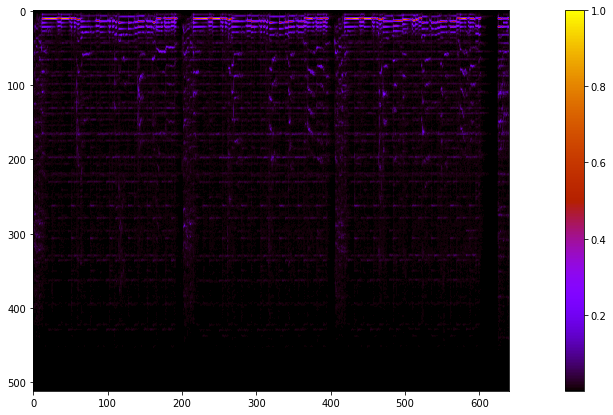

True voice


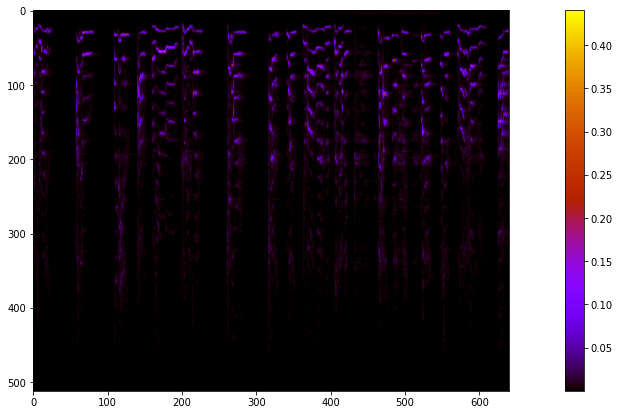

Predicted voice


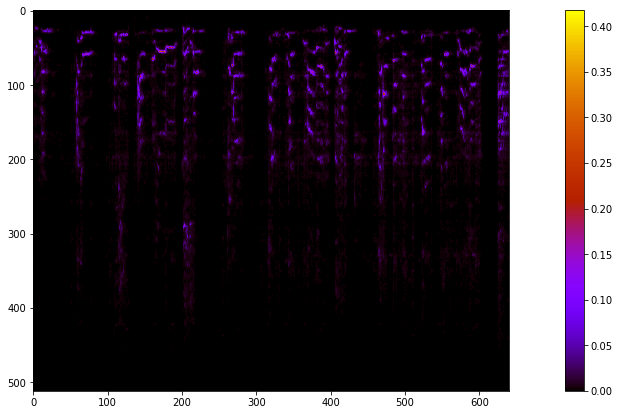

In [16]:
# essai de sortie d'une prédiction à écouter (sur Xmix[0] )

#ytest =unet.predict(X_mix[0,:,:,:].reshape(-1,nfreq,nphase,1))

mag_test=X_mix[0,:,:,0]
phase_test=np.angle(phase[0,:,:])
spec=mag_test * np.exp(1j*phase_test)
#test=ytest.reshape(nframes,nfreq)*phase[0,:,:]
y = librosa.istft(spec, window_length,hop_length)



signal = nussl.AudioSignal(audio_data_array=y, sample_rate=freq)
signal.embed_audio()
print(signal)

print("True mix")
plt.figure(figsize=(20,7))
mix_to_plot = np.concatenate([X_mix[i] for i in range(5)],axis=1)
plt.imshow(mix_to_plot[:,:,0],cmap="gnuplot")
plt.colorbar()
plt.show()

print("True voice")
plt.figure(figsize=(20,7))
mix_to_plot = np.concatenate([X_voice[i] for i in range(5)],axis=1)
plt.imshow(mix_to_plot[:,:,0],cmap="gnuplot")
plt.colorbar()
plt.show()

ytest = unet.predict(X_mix[0:10].reshape(-1,nfreq,nframes,1))
print("Predicted voice")
plt.figure(figsize=(20,7))
mix_to_plot = np.concatenate([ytest[i] for i in range(5)],axis=1)
plt.imshow(mix_to_plot[:,:,0],cmap="gnuplot")
plt.colorbar()
plt.show()